In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = '201705'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

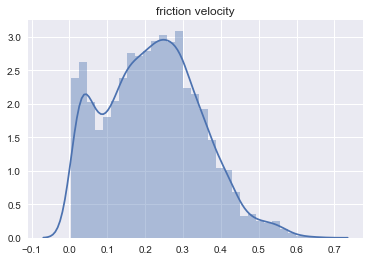

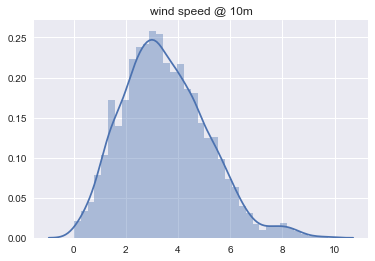

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

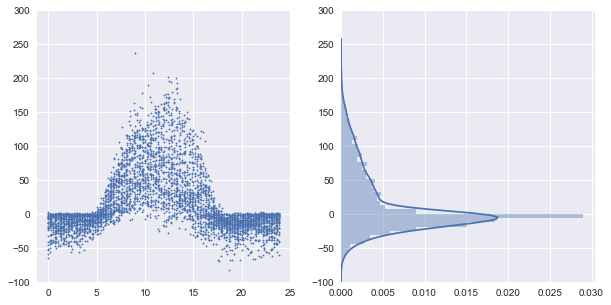

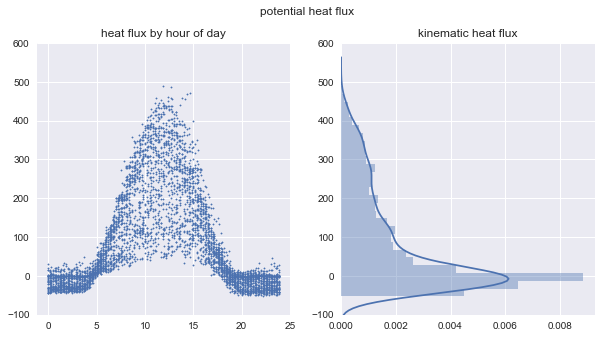

In [4]:
plt.figure(figsize=(10, 5))
plt.title('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 300)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
plt.ylim(-100, 300)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.title('heat flux by hour of day')
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.title('kinematic heat flux')
plt.ylim(-100, 600)
plt.show()

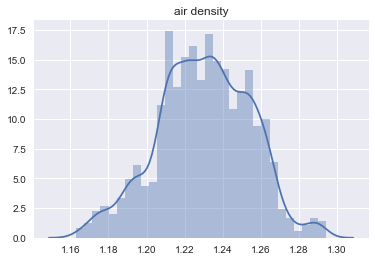

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

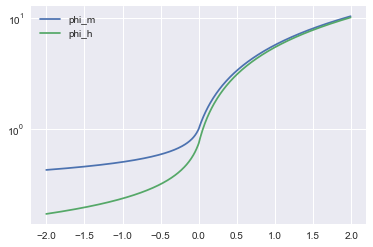

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

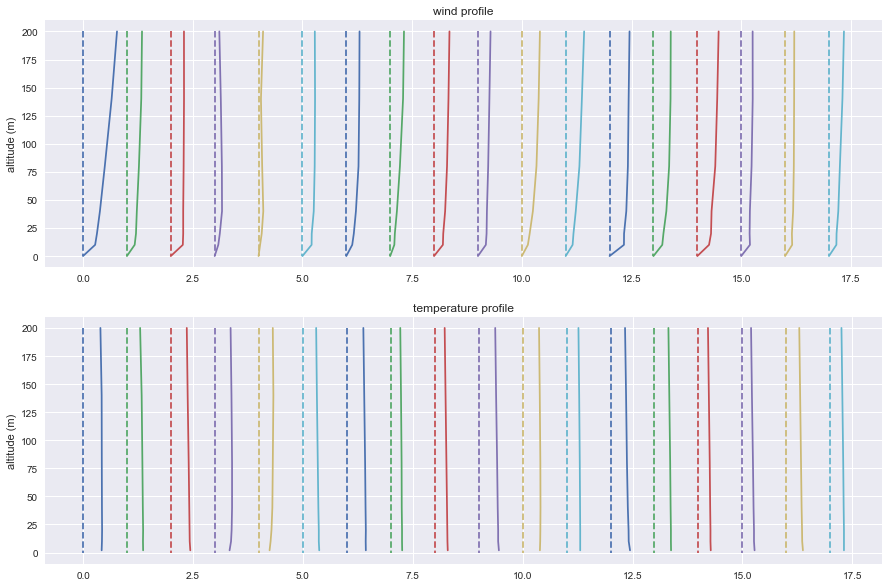

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient, obtained by weight averaging top and bottom derivatives (quantity is $x$ and altitude is $y$). Let $\Delta^+a_i=a_{i+1}-a_i$ and $\Delta^-a_i=a_i-a_{i-1}$, then

\begin{align*}
\frac{\partial x_i}{\partial y_i}
&=\frac{\Delta^+x_i}{\Delta^+y_i}\cdot\frac{\Delta^+y_i}{\Delta^+y_i+\Delta^-y_i}
+\frac{\Delta^-x_i}{\Delta^-y_i}\cdot\frac{\Delta^-y_i}{\Delta^+y_i+\Delta^-y_i} \\
&=\frac{\Delta^+x_i+\Delta^-x_i}{\Delta^+y_i+\Delta^-y_i} \\
&= \frac{x_{i+1}-x_{i-1}}{y_{i+1}-y_{i-1}}
\end{align*}

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

we fill missing values with linear interpolation. this will result in the same gradient, but at least we won't throw away the value

In [8]:
def fill_na_lerp(arr, levels=None):
    ''' fill nan/infs by interpolating from closest values
        strip left/right nan/infs
    '''
    levels = levels or np.arange(len(arr))

    def find_good_left(arr, levels):
        # for each element in arr, find the closest
        # non-na element and its level to the left
        # (if non-na, value and level will be the same)
        i = 0
        while i < len(arr) and not np.isfinite(arr[i]):
            i += 1    
        assert i < len(arr), 'only nans/infs here'

        good, good_lvl = np.zeros((2, len(arr) - i))
        good[0], good_lvl[0] = arr[i], levels[i]

        i, j = i + 1, 1
        while i < len(arr):
            if np.isfinite(arr[i]):
                good[j], good_lvl[j] = arr[i], levels[i]
            else:
                good[j], good_lvl[j] = good[j - 1], good_lvl[j - 1]
            i, j = i + 1, j + 1

        return good, good_lvl

    good_left, left_lvl = find_good_left(arr, levels)
    
    # strip left nan/infs
    arr = arr[len(arr) - len(good_left):]
    levels = levels[len(levels) - len(left_lvl):]

    good_right, right_lvl = find_good_left(list(reversed(arr)), list(reversed(levels)))
    good_right, right_lvl = list(reversed(good_right)), list(reversed(right_lvl))

    # strip right nan/infs
    arr = arr[:len(good_right)]
    levels = levels[:len(right_lvl)]
    good_left = good_left[:len(good_right)]
    left_lvl = left_lvl[:len(good_right)]

    # when val is na, l_val/r_val are the closest non-na to the left/right
    # and l_lvl/r_lvl are the their levels, then, replace val with a linear
    # interpolation from l_val to r_val at level lvl
    # i.e. (lvl - l_lvl) / (r_lvl - l_lvl) = (val - l_val) / (r_val - l_val)
    # and solve for val

    return [
        val if np.isfinite(val) else l_val + (r_val - l_val) * (lvl - l_lvl) / (r_lvl - l_lvl)
        for val, lvl, l_val, l_lvl, r_val, r_lvl in zip(
            arr, levels, good_left, left_lvl, good_right, right_lvl
        )
    ], levels


fill_na_lerp([
    np.nan, np.nan, np.nan, 1, 2, 3, np.nan, np.nan, 6, 7, np.nan, np.nan, np.nan
])

([1, 2, 3, 4.0, 5.0, 6, 7], array([3, 4, 5, 6, 7, 8, 9]))

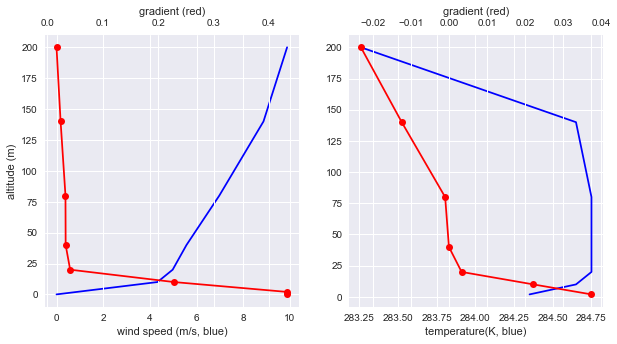

In [9]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)

    return dxdy


def get_wind_profile(tt, towmetds):
    ws = list(
        np.nan if towmetds['F'][tt].mask[i] else wind
        for i, wind in enumerate(towmetds['F'][tt].data)
    )

    zs = list(towmetds['z'][:])

    # no-slip condition
    ws.append(0)
    zs.append(0)

    ws, zs = fill_na_lerp(ws, zs)
    
    dwdz = get_derivative(zs, ws)
    return zs, ws, dwdz


def get_temperature_profile(tt, towmetds, soilds):
    ts = list(towmetds['TA'][tt][:])
    zs = list(towmetds['z'][:])

    if soilds:
        ts.append(soilds['TS00'][tt] + 273.15)
        zs.append(0)

    ts, zs = fill_na_lerp(ts, zs)
    
    dtdz = get_derivative(zs, ts)
    return zs, ts, dtdz


tt = towmetds['time'][126]

wz, ws, dwdz = get_wind_profile(tt, towmetds)
tz, ts, dtdz = get_temperature_profile(tt, towmetds, soilds)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, wz, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, wz, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, tz, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, tz, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [3]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt']
computed_cols = ['phi_m', 'phi_h', 'zL', 'dwdz', 'dtdz', 'lval']
source_cols = ['IUST', 'ILE', 'IH', 'ITA_2', 'ITA_1', 'IF_2', 'ITA002', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    try:
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        soilds = None

    for i, tt in enumerate(towmetds['time']):
        wz, ws, dwdz = get_wind_profile(tt, towmetds)
        tz, ts, dtdz = get_temperature_profile(tt, towmetds, soilds)

        # fill missing top/bottom levels with nan
        levels = [200., 140., 80., 40., 20., 10., 2., 0.]
        tz_full, ts_full, dtdz_full = [], [], []
        wz_full, ws_full, dwdz_full = [], [], []
        iw = it = 0
        for i, lvl in enumerate(levels):
            tz_full.append(lvl)
            if it < len(tz) and abs(tz[it] - lvl) < 1:
                ts_full.append(ts[it])
                dtdz_full.append(dtdz[it])
                it += 1
            else:
                ts_full.append(np.nan)
                dtdz_full.append(np.nan)

            wz_full.append(lvl)
            if iw < len(wz) and abs(wz[iw] - lvl) < 1:
                ws_full.append(ws[iw])
                dwdz_full.append(dwdz[iw])
                iw += 1
            else:
                ws_full.append(np.nan)
                dwdz_full.append(np.nan)
        
        # compute L, z/L, phi_m and phi_h for each level
        for i, (z, wind, temp, dwind, dtemp) in enumerate(zip(wz, ws, ts, dwdz, dtdz)):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            spec_hum = towmetds['Q'][tt][i]
            virtual_temp = temp * (1 + 0.61 * spec_hum)
            air_dens = 100 * meteods['P0'][tt] / (287.058 * virtual_temp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][tt] + 0.07 * fluxds['LE'][tt]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][tt]**3 * virtual_temp / (
                0.4 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.4 * z / fluxds['UST'][tt]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][tt] * 1005 * air_dens
                / fluxds['H'][tt]
            )

            yield RowRecord(
                ds=month,
                year=month[:4],
                month=month[4:],
                daym=int(tt / 24),
                hday=tt % 24,
                tt=tt,

                air_dens=air_dens,
                H=fluxds['H'][tt],
                LE=fluxds['LE'][tt],
                ustar=fluxds['UST'][tt],
                temp=temp,
                virtual_temp=virtual_temp,
                soil_temp=(273.15 + soilds['TS00'][tt]) if soilds else np.nan,
                wind=towmetds['F'][tt, -2],

                z=z,
                lval=lval,
                zL=z / lval,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][tt],
                ILE=fluxds['ILE'][tt],
                IH=fluxds['IH'][tt],
                ITA_2=towmetds['ITA'][tt][-2],
                ITA_1=towmetds['ITA'][tt][-1],
                IF_2=towmetds['IF'][tt][-2],
                ITA002=meteods['ITA002'][tt],
                IP0=meteods['IP0'][tt],

                co2flux=fluxds['FC'][tt],
                soilheat=fluxds['G0'][tt],
                netrad=fluxds['QN'][tt],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][tt][-1],
                rel_hum=towmetds['RH'][tt][-1],
                press=meteods['P0'][tt],
                rain=meteods['RAIN'][tt],
            )

In [4]:
dframe_path = 'data/cabauw/processed.csv.gz'

if not os.path.exists(dframe_path):
    print('recomputing data (you take a coffee)')
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf
    
    sc = SparkContext(conf=SparkConf()
        .setMaster('local[7]')
        .set('spark.driver.memory', '14g')
        .set('spark.driver.maxResultSize', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

    try:
        df_rows = (sc.parallelize(all_months, len(all_months))
            #.sample(fraction=7 / len(all_months), withReplacement=False)
            .flatMap(process)
            .collect())
    finally:
        sc.stop()

    df = pd.DataFrame(df_rows)
    df.to_csv(dframe_path, index=False)


try:
    df = pd.read_csv(dframe_path, na_values='--')
except (OSError, UnicodeDecodeError):
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

print(len(df), 'recods')

3558528 recods


we can remove some data known to be of bad quality, i.e. $u_*<0.1$ and $\vert H\vert<10$

In [5]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]

we also remove data from 201603 as it contains bad measurements for the fluxes

In [6]:
df[df.ds == 201603][['H', 'LE']].describe().T

count        mean          std          min        25%        50%  \
H   13368.0  316.126351  6203.482368 -1552.988037 -59.778019 -22.506733   
LE  13296.0   24.658386   426.851504 -6601.955600 -23.895859  29.174152   

           75%            max  
H    24.910757  144691.765625  
LE  113.092880    1549.666400

In [7]:
df = df[df.ds != 201603]

In [8]:
df[additional_cols].describe(include='all').T

count         mean         std         min          25%  \
dewpoint  2083992.0   280.468050    7.867914  190.449661   277.120544   
spec_hum  2083992.0     6.720645    2.486454   -0.656552     4.909316   
rel_hum   2083992.0    78.189443   16.435867    0.007615    68.681458   
press     2083992.0  1013.570328   10.042048  978.400024  1007.700012   
rain      2083992.0     0.016705    0.125581   -0.016667     0.000000   
co2flux   2083992.0    -0.057160    0.289579   -3.049525    -0.239812   
soilheat  2083992.0     2.732912   15.069267  -69.496613    -6.533778   
netrad    2083992.0    79.830027  167.649810 -109.265366   -35.971527   

                  50%          75%          max  
dewpoint   281.145752   285.281860   296.544373  
spec_hum     6.398771     8.440201    17.614822  
rel_hum     81.777893    90.634842   109.266533  
press     1014.299988  1020.500000  1040.500000  
rain         0.000000     0.000000     7.916667  
co2flux      0.036510     0.120055     5.244211  
soilheat    -0.967758     8.768829   106.169769  
netrad      -4.088165   165.010315   770.600830

In [9]:
df[measurement_cols].describe(include='all').T

count         mean         std         min          25%  \
air_dens      2083992.0     0.270823    0.109295    0.099593     0.198636   
H             2083992.0     1.995475   46.265634 -459.999756   -26.539051   
LE            2083992.0    74.735474  116.087414 -117.415665    -5.016693   
ustar         2083992.0     0.308456    0.143101    0.100004     0.200044   
wind          2083992.0     5.170168    2.344852    1.002586     3.440000   
temp          2083992.0   284.863902    6.517343  259.350006   280.250000   
virtual_temp  2083992.0  1460.923170  461.977332  173.999282  1121.965956   
soil_temp     1773456.0   284.473898    5.728240  272.583312   279.767470   
z             2083992.0    18.000000   14.212674    2.000000     8.000000   

                      50%          75%          max  
air_dens         0.252563     0.314198     2.005090  
H              -15.339976    26.067751   459.924530  
LE              22.696487   129.485170   595.862700  
ustar            0.284211     0.386544     1.313813  
wind             4.720000     6.430000    19.219999  
temp           284.750000   289.449982   306.549988  
virtual_temp  1396.287410  1777.019847  3524.099606  
soil_temp      284.527413   289.272835   301.509936  
z               15.000000    25.000000    40.000000

In [10]:
df[computed_cols].describe(include='all').T

count        mean          std           min        25%        50%  \
phi_m  2083992.0    2.259633     1.624596     -4.444776   1.152037   1.667535   
phi_h  2083992.0    0.086678     0.556104    -20.409393  -0.093874   0.104911   
zL     2083992.0   -0.056324     1.938176    -82.806393  -0.114032   0.035299   
dwdz   2083992.0    0.218438     0.235459     -0.097333   0.044934   0.099106   
dtdz   2083992.0    0.009848     0.121258     -1.058651  -0.013333  -0.003334   
lval   2083992.0  111.239142  1347.388074 -56474.352644 -19.579466  25.111862   

              75%            max  
phi_m    3.215870      15.496656  
phi_h    0.271943      22.172533  
zL       0.247012      27.904544  
dwdz     0.336000       1.922000  
dtdz     0.016666       1.160954  
lval   126.304888  326253.666461

In [11]:
df[index_cols].describe(include='all').T

count           mean         std       min       25%  \
ds     2083992.0  200894.975493  484.941706  200101.0  200504.0   
year   2083992.0    2008.885907    4.848958    2001.0    2005.0   
month  2083992.0       6.384750    3.397909       1.0       4.0   
daym   2083992.0      14.729907    8.747416       0.0       7.0   
hday   2083992.0      11.969246    6.941020       0.0       6.0   
tt     2083992.0     365.487010  210.027104       0.0     189.0   

                 50%            75%            max  
ds     200905.000000  201307.000000  201712.000000  
year     2009.000000    2013.000000    2017.000000  
month       6.000000       9.000000      12.000000  
daym       15.000000      22.000000      30.000000  
hday       12.000015      18.000004      23.833374  
tt        363.000000     543.333313     743.833374

In [12]:
df[source_cols].describe(include='all').T

count      mean       std  min  25%  50%  75%  max
IUST    2083992.0  2.266051  0.700490  2.0  2.0  2.0  2.0  7.0
ILE     2083992.0  2.448804  1.253607  2.0  2.0  2.0  2.0  7.0
IH      2083992.0  2.428443  1.222327  2.0  2.0  2.0  2.0  7.0
ITA_2   2083992.0  2.017136  0.267394  2.0  2.0  2.0  2.0  7.0
ITA_1   2083992.0  2.013232  0.225712  2.0  2.0  2.0  2.0  7.0
IF_2    2083992.0  2.013981  0.227218  2.0  2.0  2.0  2.0  7.0
ITA002  2083992.0  2.013232  0.225712  2.0  2.0  2.0  2.0  7.0
IP0     2083992.0  3.040492  0.395779  3.0  3.0  3.0  3.0  7.0

plot correlation matrix between data, computed values, and time of year (to check seasonality)

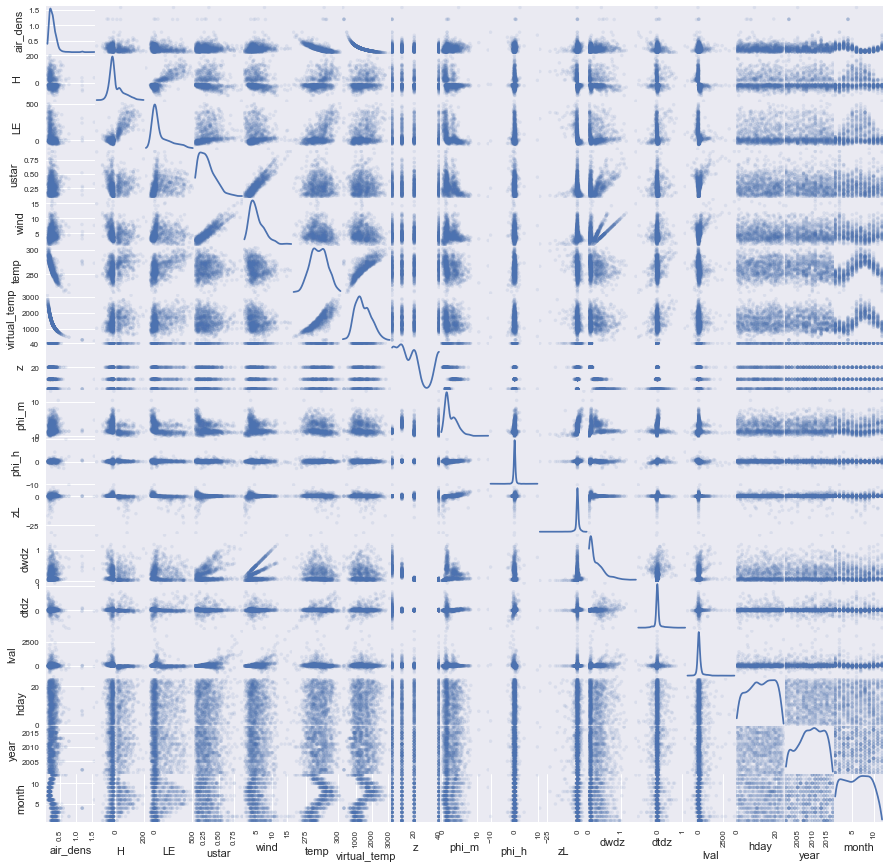

In [13]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

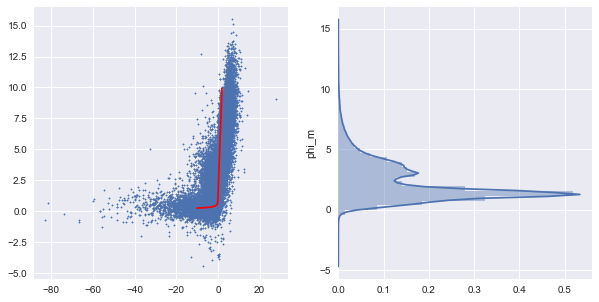

In [43]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-10, 10)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)

plt.show()

the data can be made to fit the line by doubling phi_m, or halving z/L

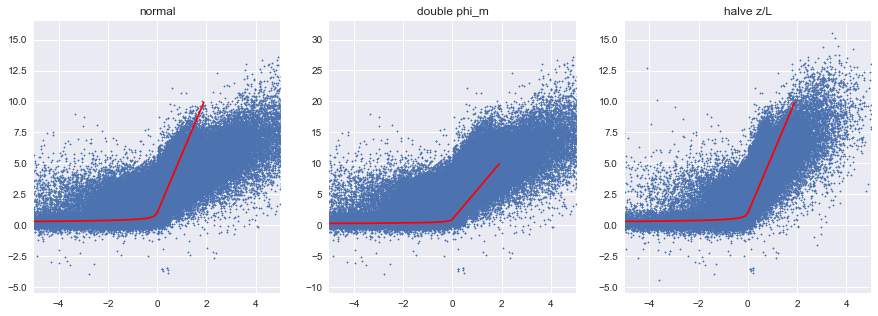

In [38]:
xx = np.arange(-10, 2, 0.1)
phimx = list(map(phi_m ,xx))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('normal')
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)

plt.subplot(1, 3, 2)
plt.title('double phi_m')
plt.scatter(df.zL, df.phi_m * 2, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)

plt.subplot(1, 3, 3)
plt.title('halve z/L')
plt.scatter(df.zL / 2, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)
plt.show()

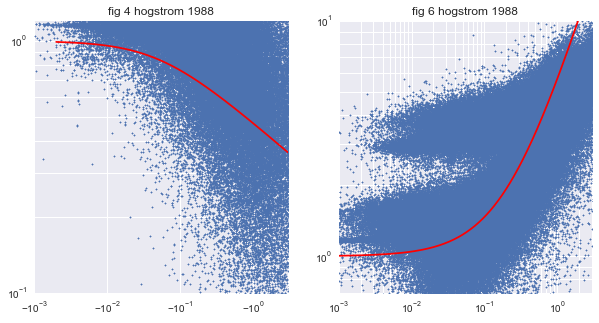

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-3, -0.001, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(-3, -0.001)
plt.xscale('symlog', linthreshx=0.001)
plt.ylim(0.1, 1.2)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(0.001, 3, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(0.001, 3)
plt.xscale('log')
plt.ylim(0.7, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

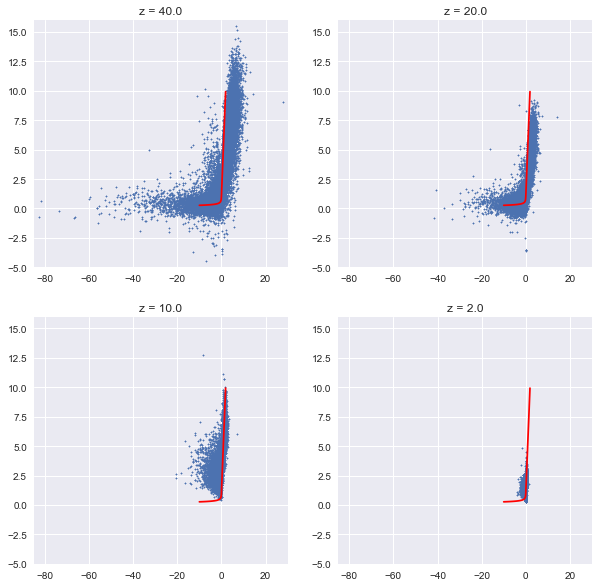

In [46]:
plt.figure(figsize=(10, 10))
for i, z in enumerate(df.z.unique()):
    plt.subplot(2, 2, i + 1)
    plt.title('z = %.1f' % z)
    plt.scatter(df[df.z == z].zL, df[df.z == z].phi_m, s=1)
    plt.plot(xx, phimx, 'r')
    plt.xlim(-85, 30)
    plt.ylim(-5, 16)
plt.show()

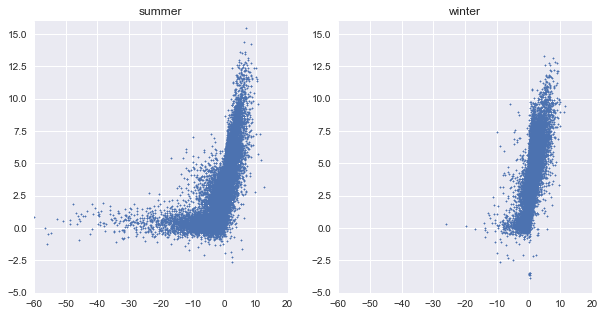

In [49]:
winter = [11, 12, 1, 2]
summer = [6, 7, 8]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('summer')
plt.scatter(df[df.month.isin(summer)].zL, df[df.month.isin(summer)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)

plt.subplot(1, 2, 2)
plt.title('winter')
plt.scatter(df[df.month.isin(winter)].zL, df[df.month.isin(winter)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)
plt.show()

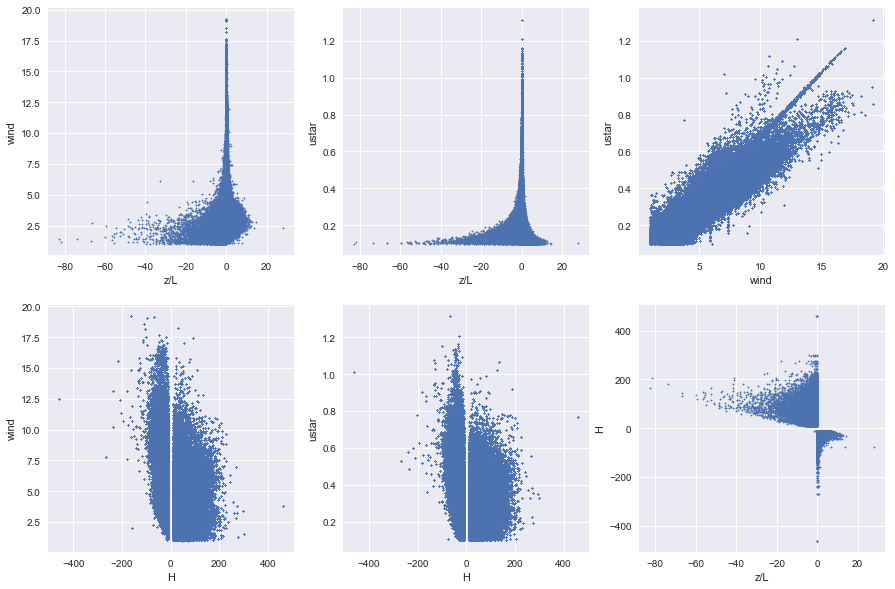

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

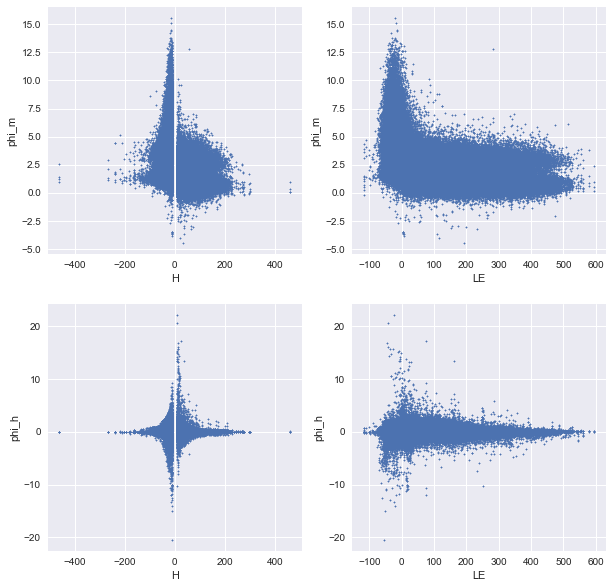

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LE'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

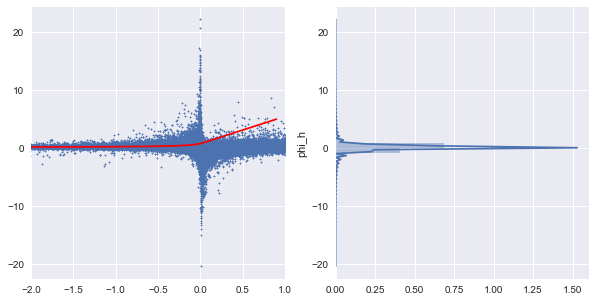

In [32]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

seems wrong. perhaps because I am using measured air temperature and not virtual temperature?

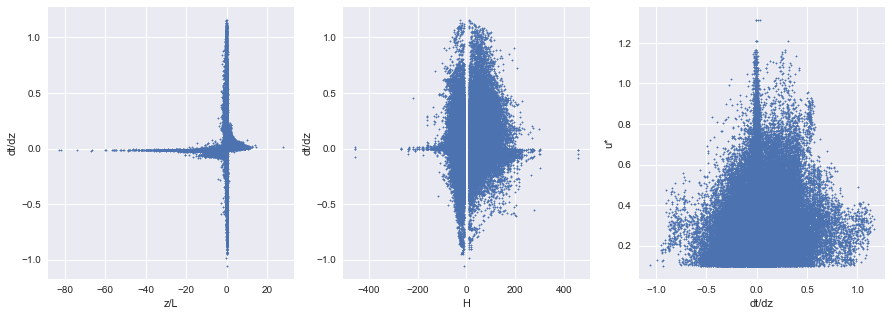

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()

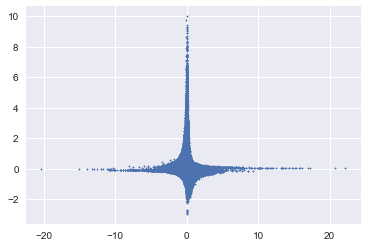

In [34]:
plt.scatter(df.phi_h, df.H / (1005 * df.air_dens * df.ustar), s=1)

very strong correlation with the previous sample, and 6 days seasonality very clear

## Checking $\phi_m$

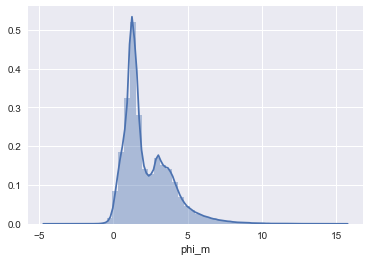

In [33]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [34]:
ints = [-3, 0, 1, 2, 4, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[-3,0)	18636
[0,1)	368706
[1,2)	805506
[2,4)	604026
[4,25)	287034


In [35]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

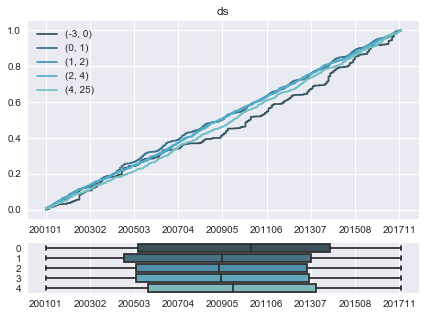

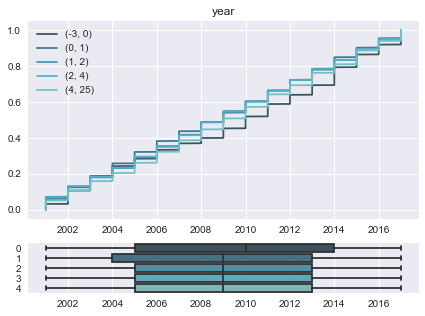

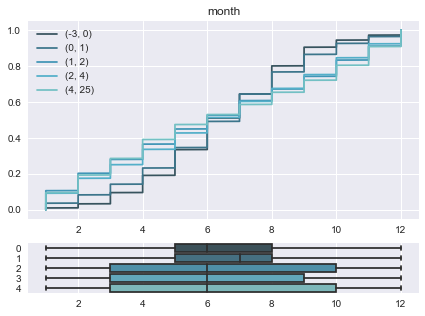

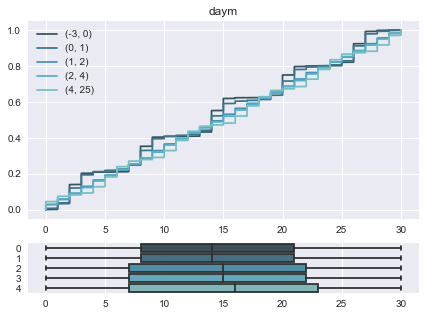

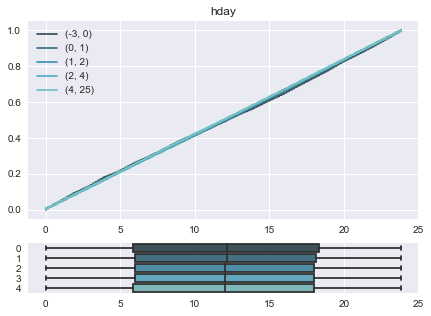

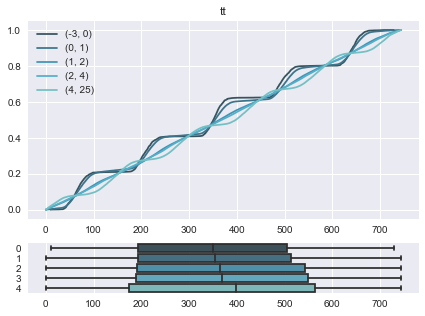

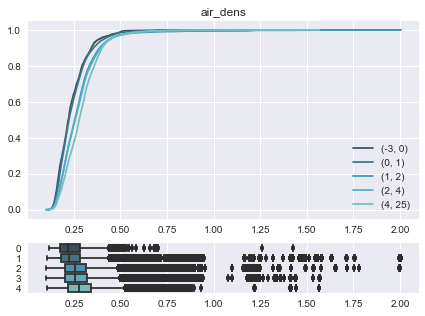

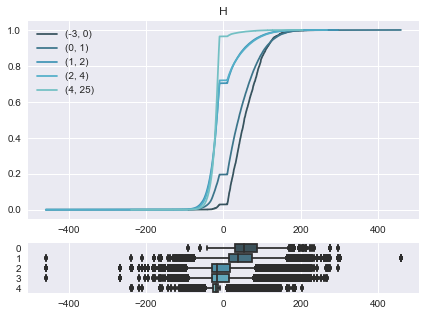

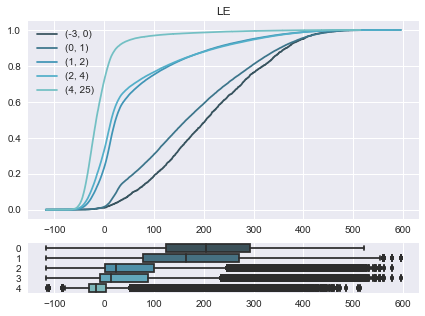

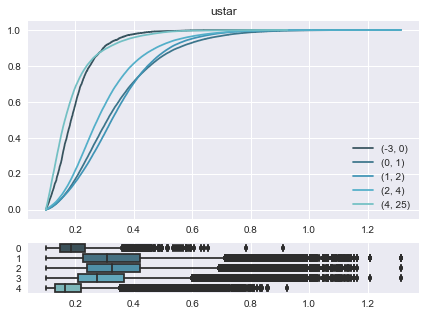

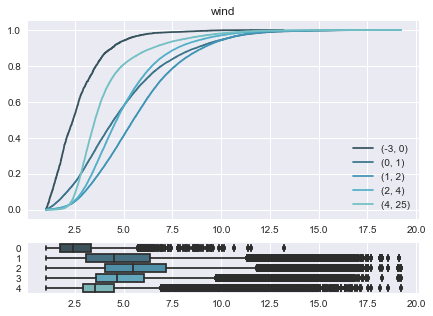

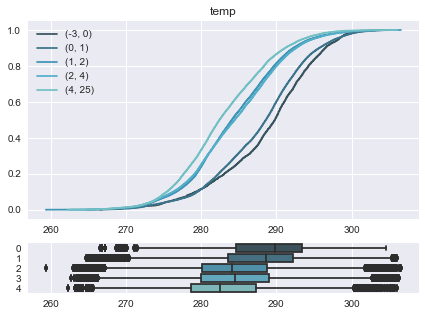

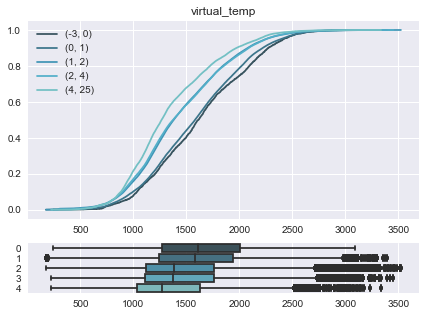

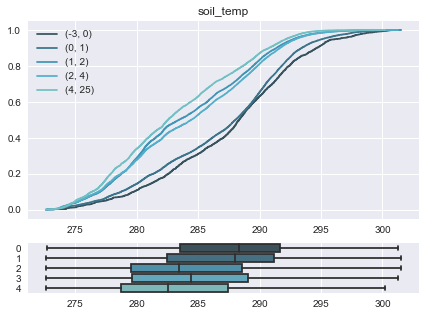

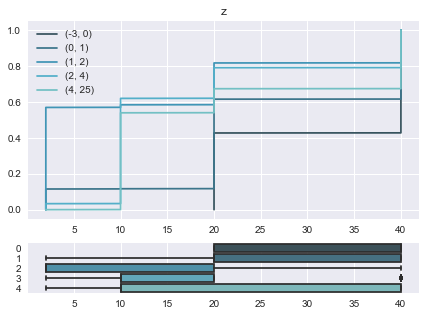

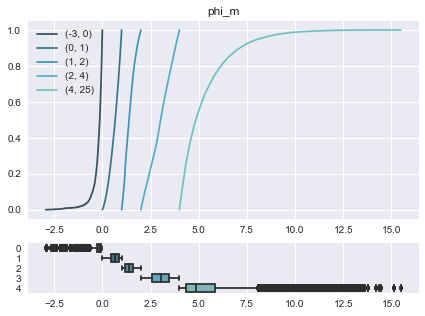

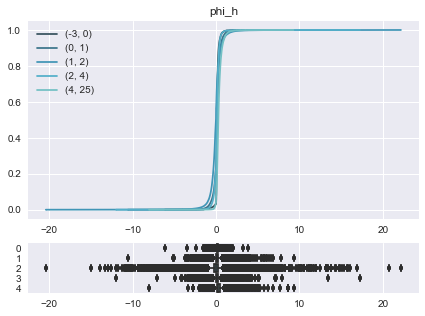

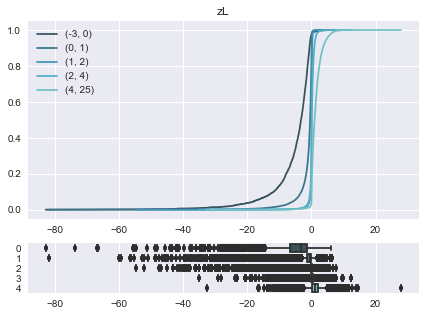

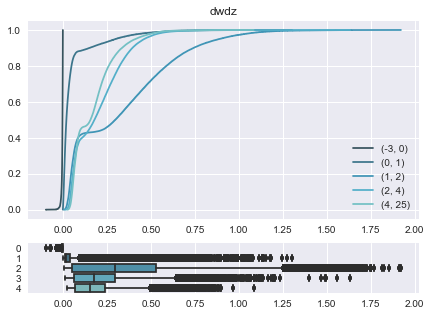

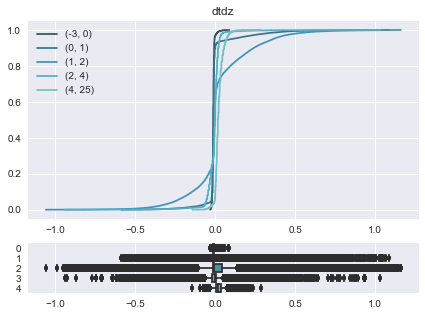

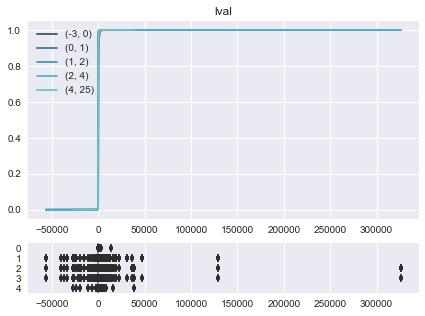

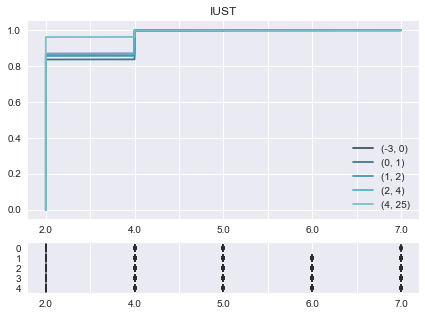

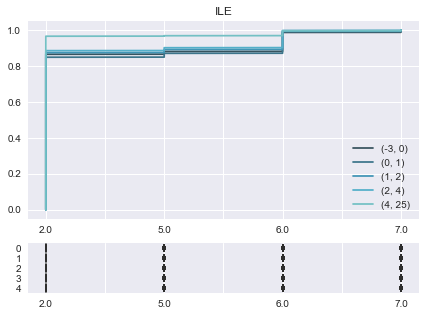

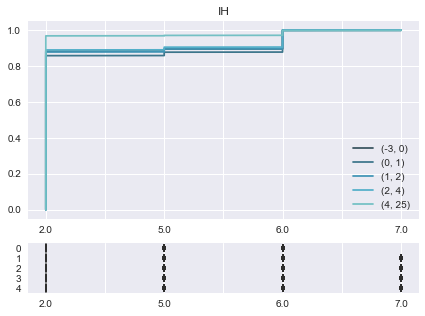

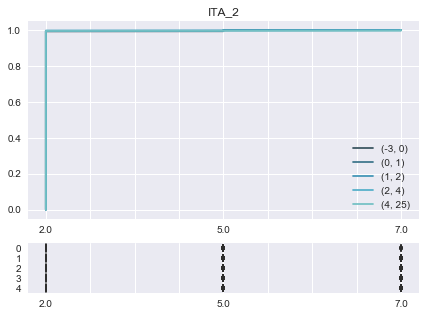

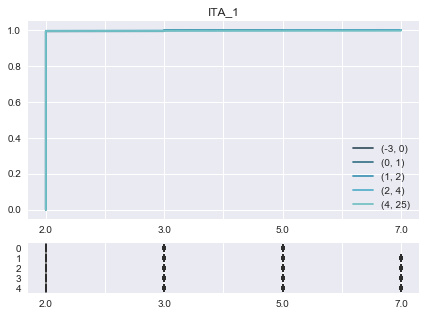

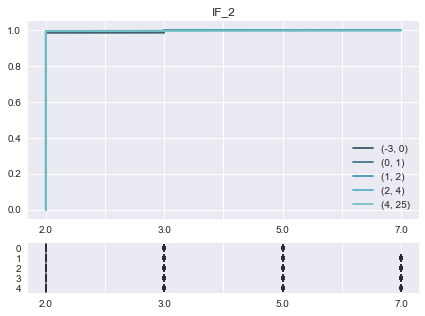

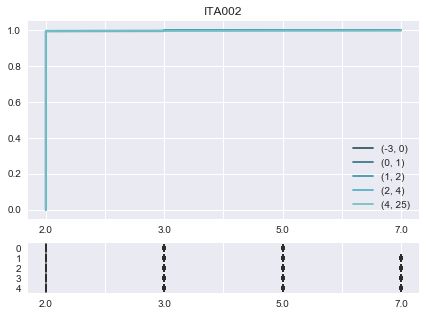

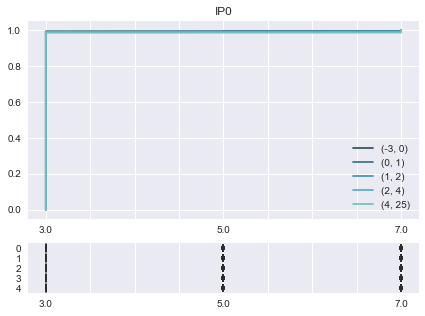

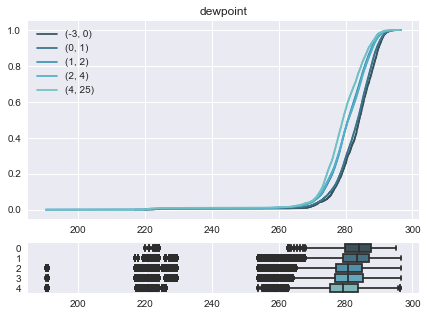

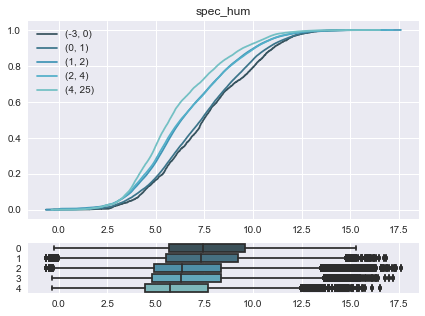

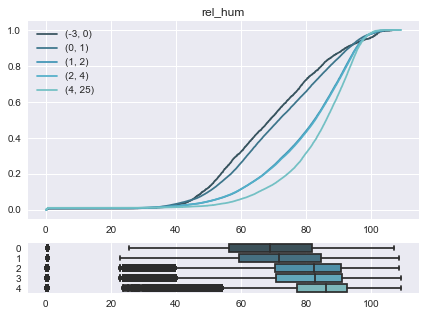

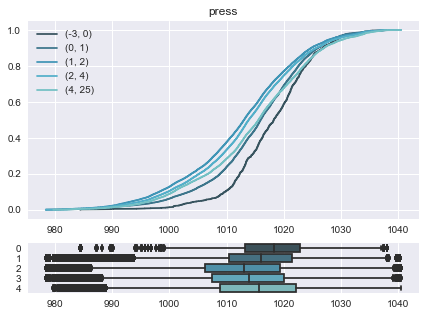

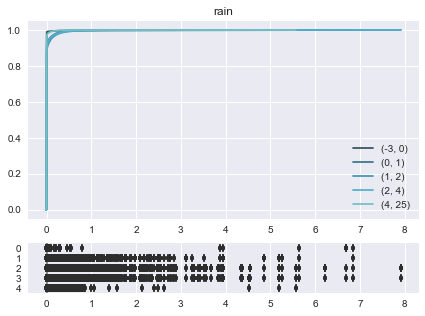

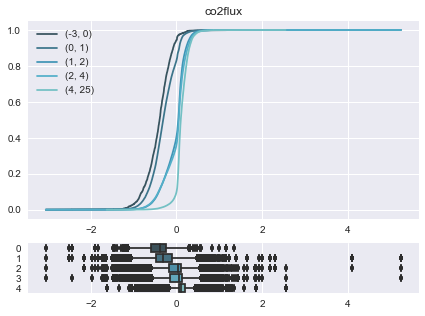

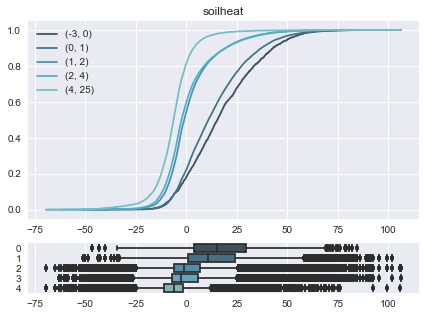

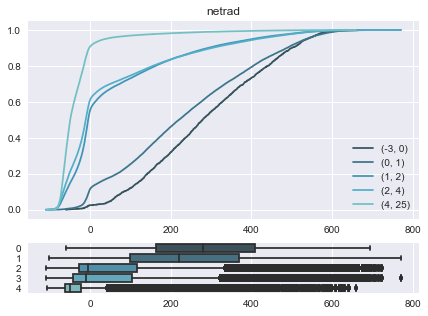

In [36]:
for col in df.columns:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - denser air
 - colder surface temperature
 - more wind
 - larger and mostly positive temperature gradient
 - lower heat fluxes

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

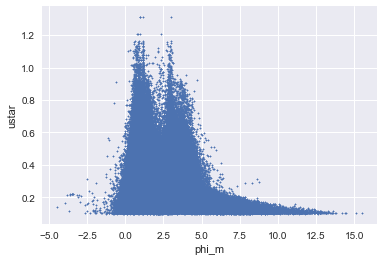

In [37]:
df.plot.scatter('phi_m', 'ustar', s=1)

there seems to be a curious pattern in the time of the month when data with small and large phi values is obtained:

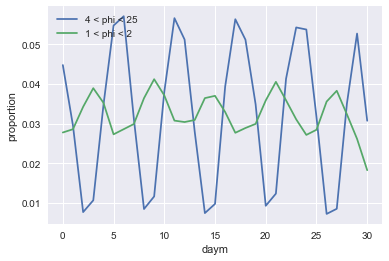

In [38]:
small_mask = (df.phi_m > 4) & (df.phi_m < 25)
large_mask = (df.phi_m > 1) & (df.phi_m < 2)

plt.plot(df[small_mask].groupby(df.daym).size() / len(df[small_mask]), label='4 < phi < 25')
plt.plot(df[large_mask].groupby(df.daym).size() / len(df[large_mask]), label='1 < phi < 2')
plt.xlabel('daym')
plt.ylabel('proportion')
plt.legend()
plt.show()

this pattern happens for other measured variables

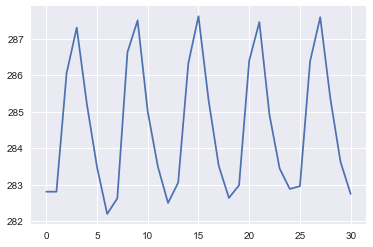

In [39]:
plt.plot(df.groupby(df.daym).temp.mean())

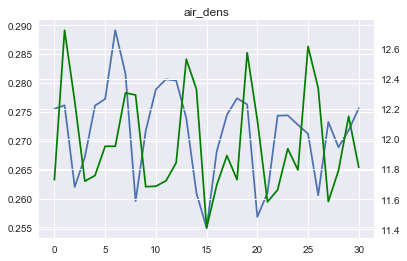

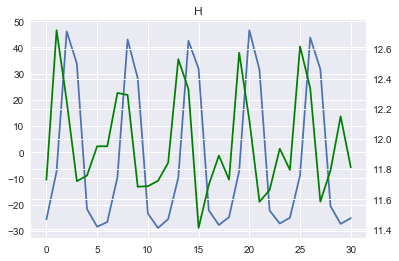

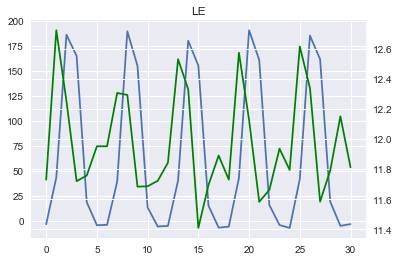

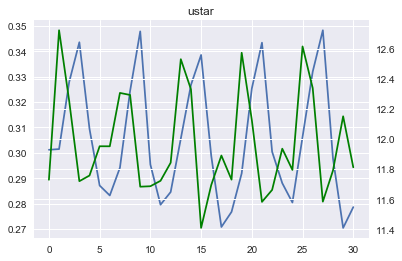

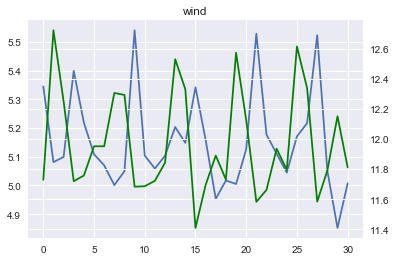

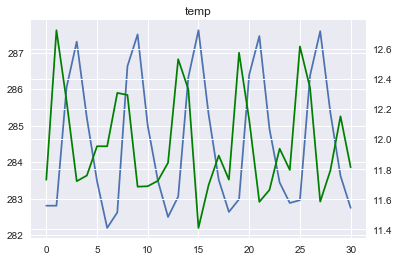

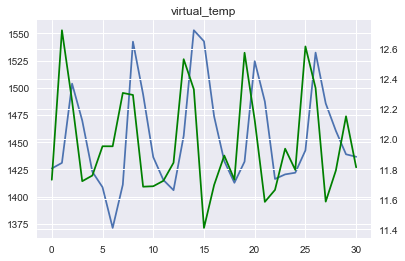

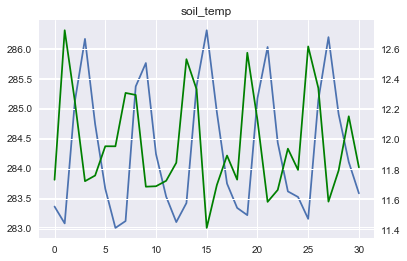

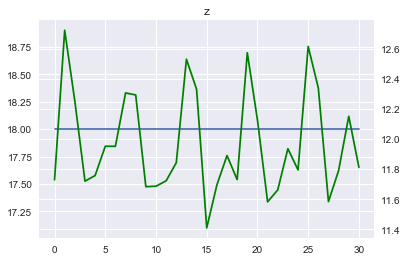

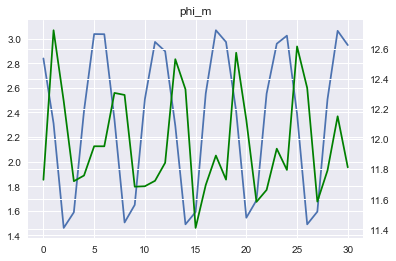

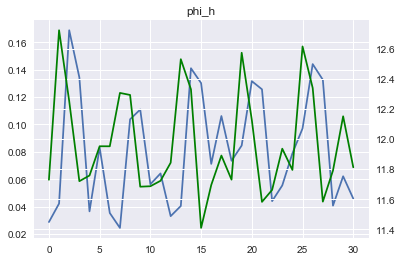

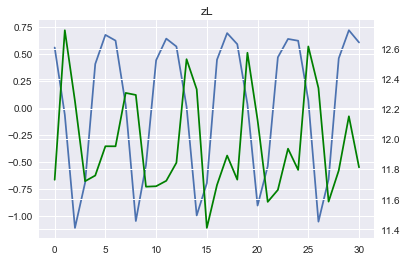

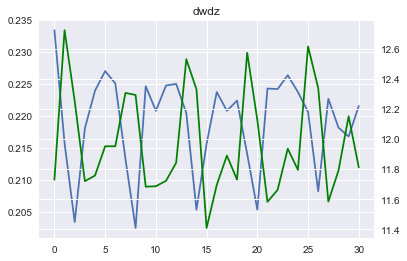

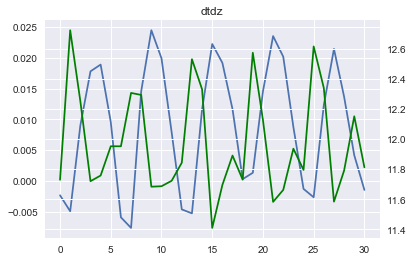

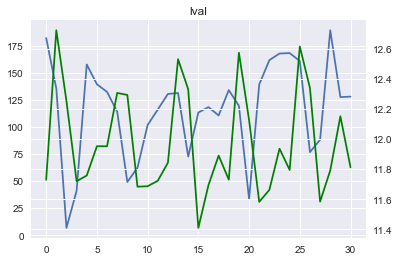

In [40]:
for var in measurement_cols + computed_cols:
    plt.plot(df.groupby(df.daym)[var].mean())
    ax2=plt.gca().twinx()
    ax2.plot(df.groupby(df.daym).hday.mean(), c='g')
    plt.title(var)
    plt.show()

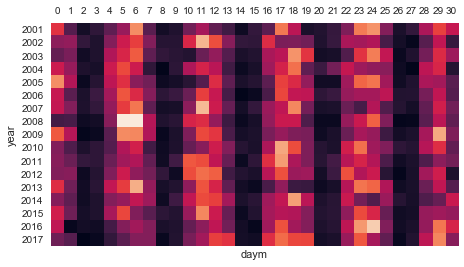

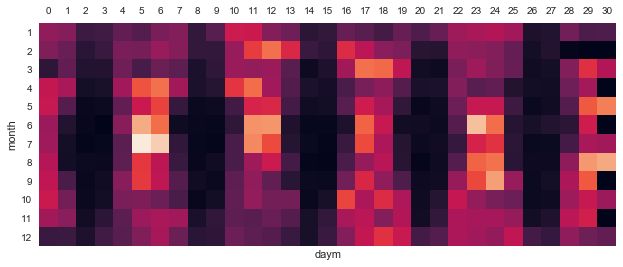

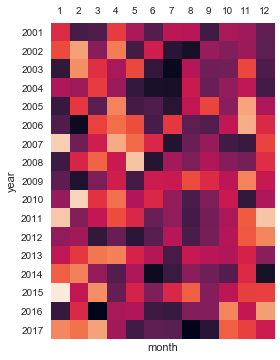

In [41]:
def matcount(row, col, transpose=False, norm=False):
    mat = (df[small_mask]
        .groupby(row)[col].value_counts()
        .rename('count').reset_index()
        .pivot(index=col, columns=row)
        .fillna(0).as_matrix())

    if norm:
        mat = mat / mat.sum(axis=0)
    
    if transpose:
        mat = mat.T
        row, col = col, row

    plt.matshow(mat)
    plt.xticks(range(len(df[row].unique())), sorted(df[row].unique()))
    plt.yticks(range(len(df[col].unique())), sorted(df[col].unique()))
    plt.xlabel(row)
    plt.ylabel(col)
    plt.grid(False)


matcount('year', 'daym', True, True) # normalize by year, transpose to plot horizontally
matcount('month', 'daym', True, True) # normalize by month, transpose to plot horizontally
matcount('month', 'year')

seems like the 6 days seasonality does not depend on the year nor on the month of the year, if we take into account the fact that some months have way more measures than others

what bothers me is that this 6 days cycle repeats more or less regularly for more than 15 years

<Container object of 40 artists>

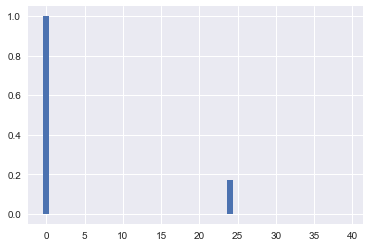

In [42]:
vs = pacf(df.sort_values(['ds', 'tt']).wind)
plt.bar(range(len(vs) - 1), vs[1:])

## inspect z/L (for phi_m)

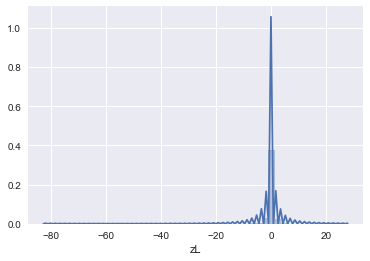

In [43]:
sns.distplot(df.zL)

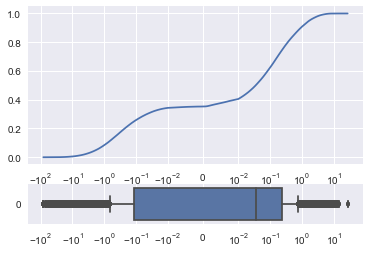

In [44]:
ax1, ax2 = plot_cdf([df.zL], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [45]:
bins = [
    -90, -1, 0, 1, 30
]

(df.zL.groupby(np.digitize(df.zL, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-9e+01, -1e+00)     175254
[-1e+00,  0e+00)     560034
[ 0e+00,  1e+00)    1154412
[ 1e+00,  3e+01)     194292
Name: zL, dtype: int64

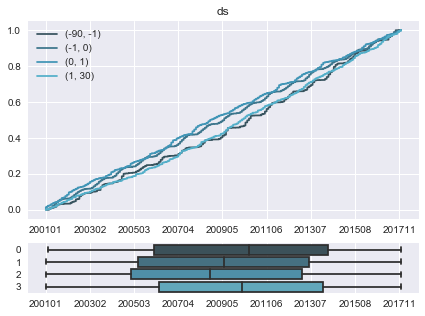

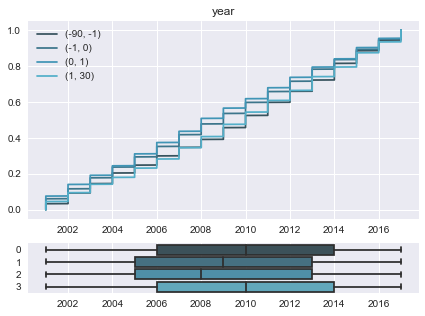

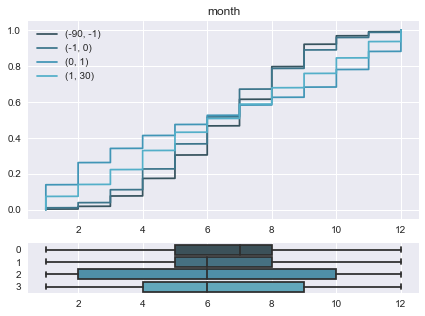

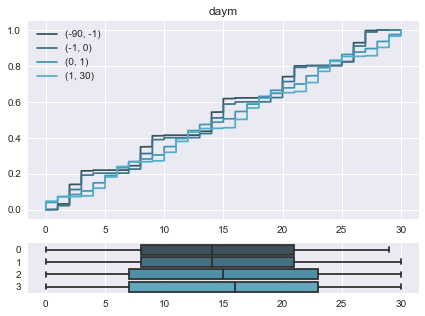

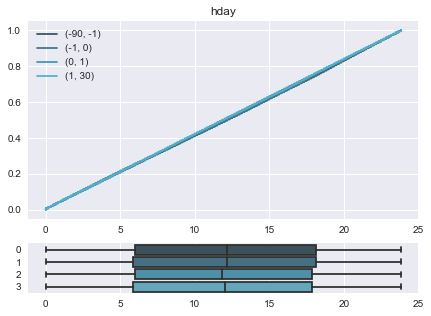

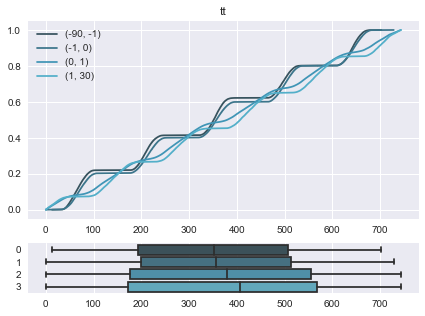

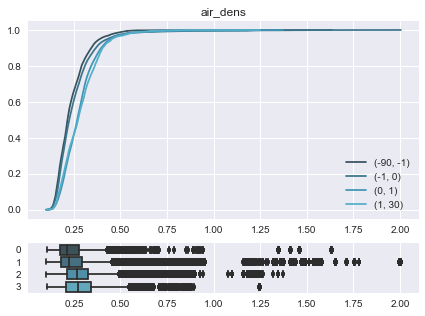

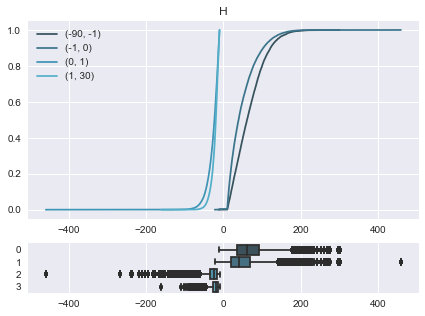

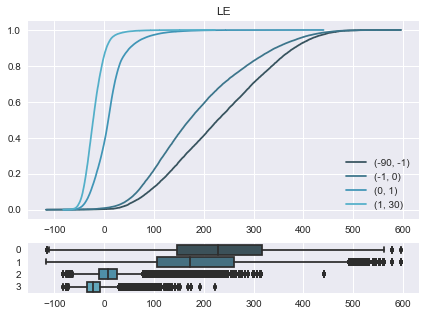

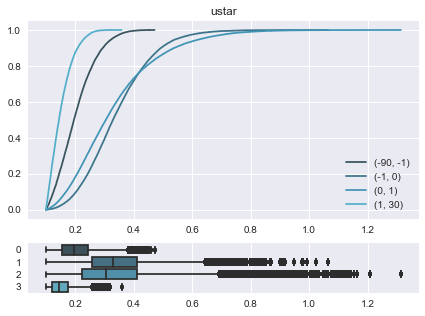

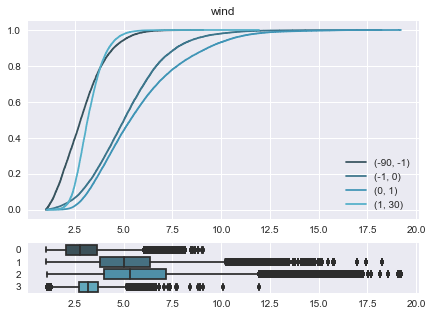

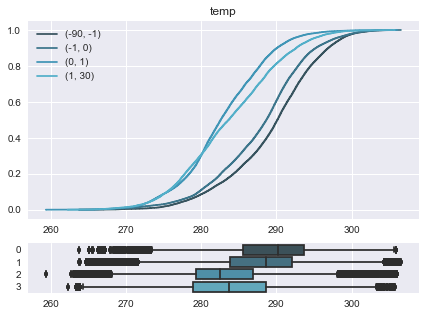

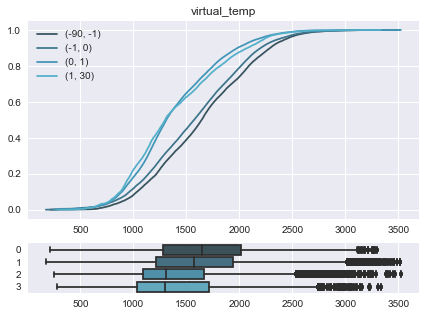

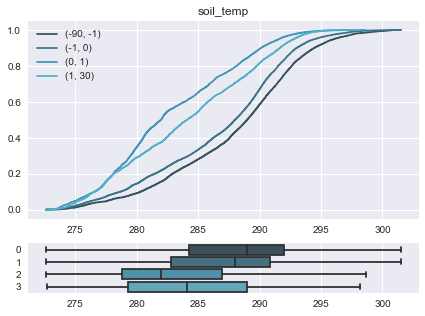

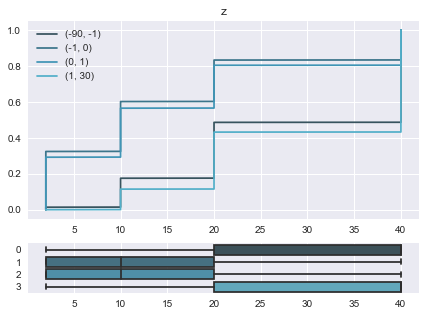

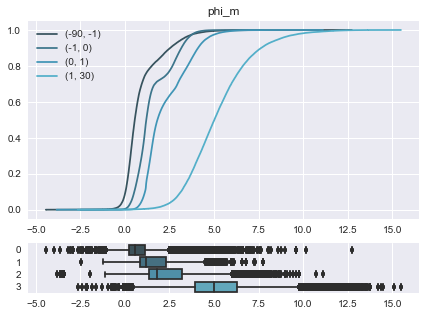

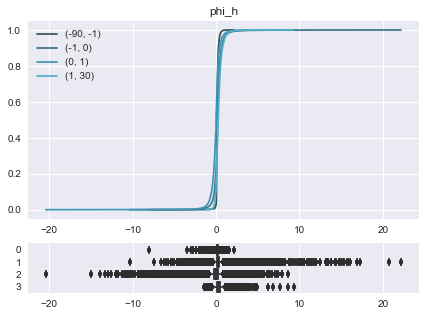

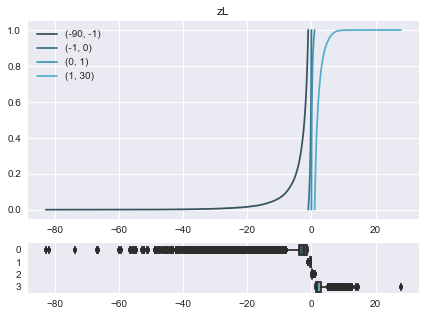

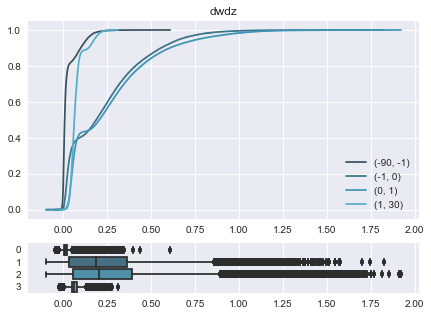

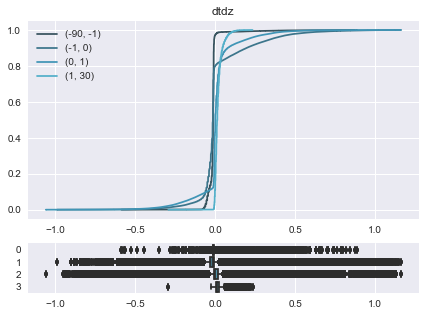

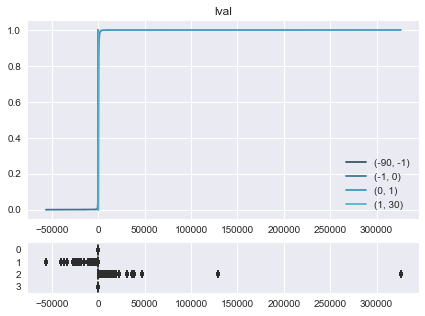

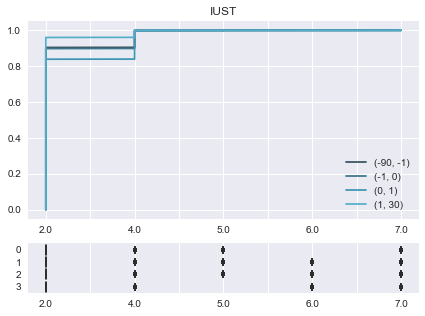

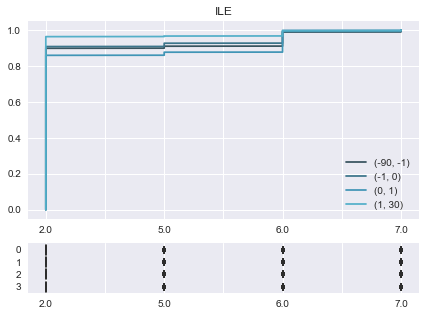

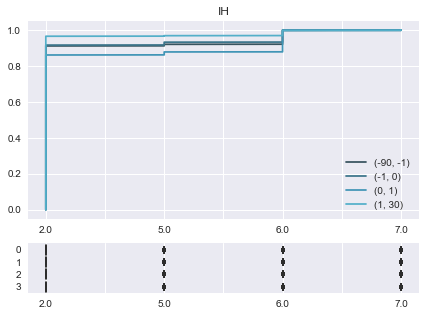

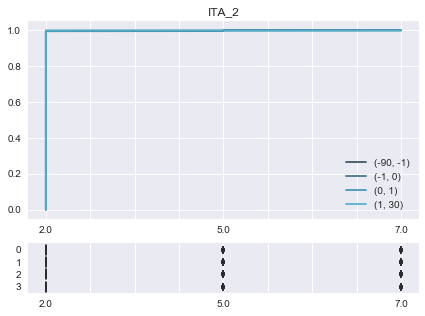

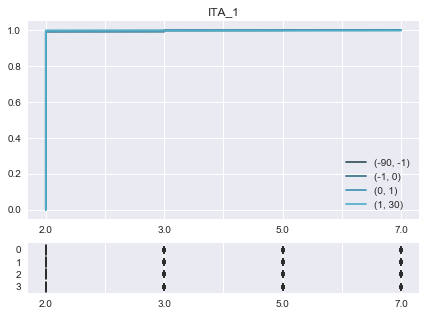

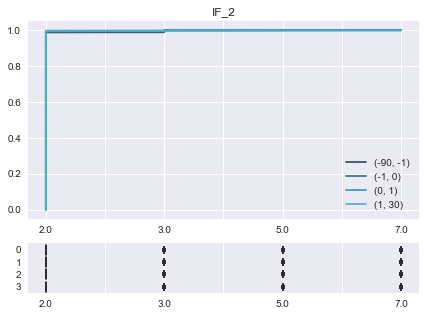

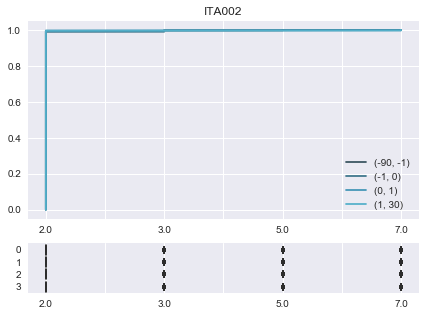

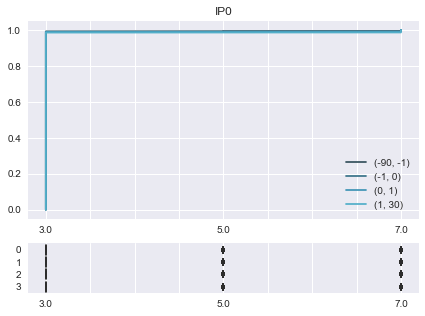

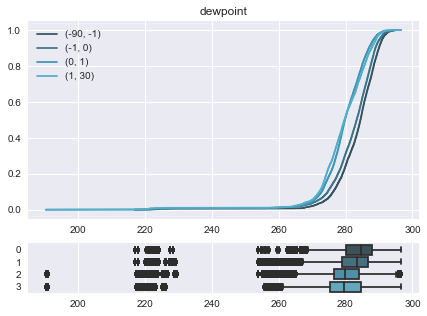

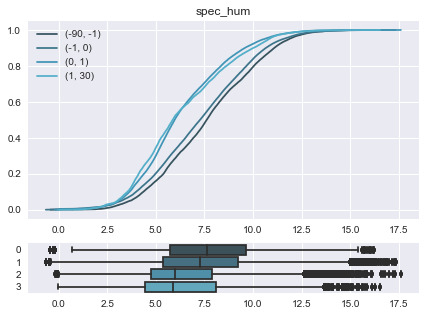

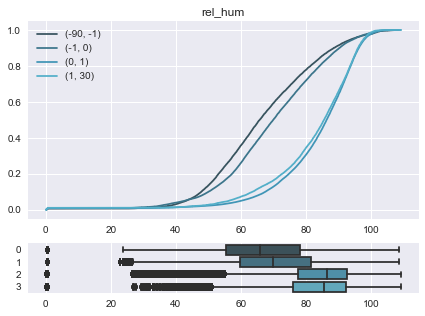

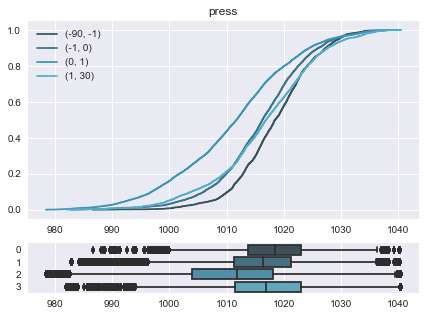

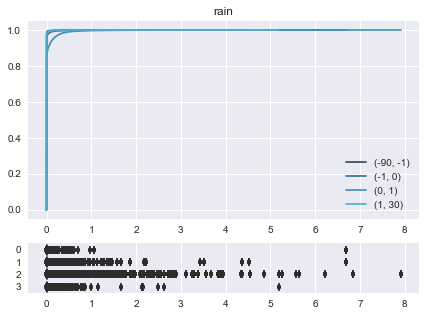

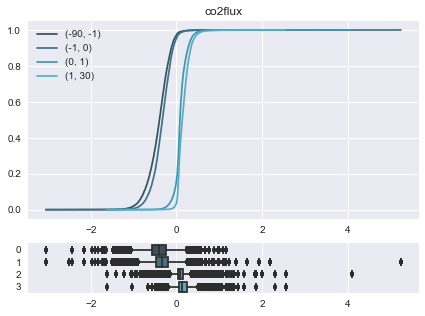

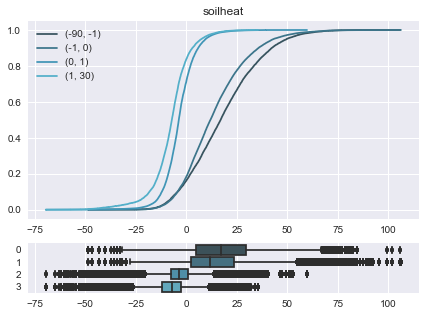

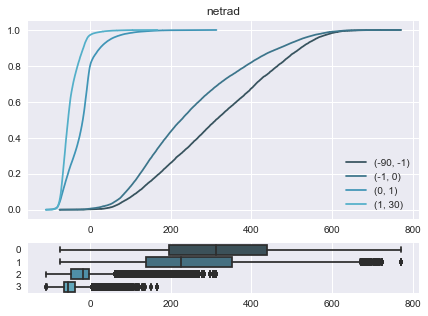

In [46]:
for col in df.columns:
    inspect_col(col, 'zL', bins)

In [47]:
(df.groupby(np.digitize(df.zL, bins))
     [['ustar', 'wind', 'LE', 'temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

ustar      wind          LE        temp     phi_m
[   -90,     -1)  0.204615  2.919998  232.515186  289.412085  0.908127
[    -1,      0)  0.342395  5.177422  189.042009  287.891937  1.547714
[     0,      1)  0.333960  5.832208   11.287368  282.878798  2.308744
[     1,     30)  0.152751  3.245343  -20.079633  283.828031  5.238968